### 전처리

In [ ]:
# 1. 라이브러리 설치
!pip install timm -q

In [ ]:
# 2. import
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import scipy.signal as signal
from scipy.io.wavfile import write
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.models as models
import timm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.manifold import TSNE
from tqdm.auto import tqdm
import IPython.display as ipd
from google.colab import drive

In [ ]:
# 3. 드라이브 마운트
drive.mount('/content/drive')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🔥 System Ready. Device: {device}")

Mounted at /content/drive
🔥 System Ready. Device: cpu


In [ ]:
# 4. 드라이브 경로
input_f_dir = '/content/drive/MyDrive/Data_F_Ind_1_3750'  # 뇌전증 (Focal)
input_n_dir = '/content/drive/MyDrive/Data_N_Ind_1_3750'  # 정상 (Non-Focal)
output_dir = '/content/drive/MyDrive/Brain_Audio_Project_WAV1' # 변환된 WAV 저장 경로

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"📂 저장 폴더 생성: {output_dir}")

📂 저장 폴더 생성: /content/drive/MyDrive/Brain_Audio_Project_WAV1


#### 2. 텍스트 ➔ WAV 변환

In [ ]:
def butter_bandpass_filter(data, lowcut=0.5, highcut=60, fs=173.61, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return signal.filtfilt(b, a, data)

def convert_and_load_data(input_dir, output_dir, label_name, label_int):
    files = sorted(glob.glob(os.path.join(input_dir, '*.txt')))
    print(f"📂 '{label_name}' 데이터 로드 중 ({len(files)}개)...")

    file_paths = []

    for file in tqdm(files):
        try:
            # 변환된 파일명
            filename = os.path.basename(file).replace('.txt', '.wav')
            save_path = os.path.join(output_dir, f"{label_name}_{filename}")

            # 이미 변환된 파일이 없으면 새로 생성
            if not os.path.exists(save_path):
                # 텍스트 읽기
                try:
                    df = pd.read_csv(file, header=None, engine='c', sep=',')
                except:
                    df = pd.read_csv(file, header=None, engine='python', sep=None)

                if df.shape[1] >= 2:
                    sig = df.mean(axis=1).values
                else:
                    sig = df.iloc[:, 0].values.flatten()

                # [핵심] 필터링만 하고 클리핑(자르기)은 하지 않음!
                sig = butter_bandpass_filter(sig)

                # 단순 정규화 (소리 크기만 맞춤)
                sig = sig / (np.max(np.abs(sig)) + 1e-8)

                # 저장
                write(save_path, 16000, sig.astype(np.float32))

            file_paths.append(save_path)
        except:
            continue

    return file_paths, [label_int] * len(file_paths)


In [ ]:
# 데이터 준비 실행
print("🚀 데이터 전처리 및 로딩 시작...")
files_f, labels_f = convert_and_load_data(input_f_dir, output_dir, "Focal", 1)
files_n, labels_n = convert_and_load_data(input_n_dir, output_dir, "Normal", 0)

# 전체 데이터 합치기
X_all = files_f + files_n
y_all = labels_f + labels_n
print(f"✅ 총 데이터 개수: {len(X_all)}개 (준비 완료)")

# Train/Test 분리
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42, stratify=y_all)


🚀 데이터 전처리 및 로딩 시작...
📂 'Focal' 데이터 로드 중 (750개)...


  0%|          | 0/750 [00:00<?, ?it/s]

📂 'Normal' 데이터 로드 중 (750개)...


  0%|          | 0/750 [00:00<?, ?it/s]

✅ 총 데이터 개수: 1500개 (준비 완료)


In [ ]:
# --- 4. 데이터셋 & 로더 정의 ---
CONFIG = {
    'sr': 16000, 'duration': 3, 'n_mels': 64, 'img_size': 224, 'batch_size': 32
}

class EfficientDataset(Dataset):
    def __init__(self, file_list, labels, config, mode='train'):
        self.file_list = file_list
        self.labels = labels
        self.config = config
        self.resize = T.Resize((config['img_size'], config['img_size']), antialias=True)

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        path = self.file_list[idx]
        label = self.labels[idx]
        try:
            y, sr = librosa.load(path, sr=self.config['sr'])
            y, _ = librosa.effects.trim(y, top_db=20)
            target_len = int(self.config['sr'] * self.config['duration'])

            if len(y) < target_len:
                y = np.pad(y, (0, target_len - len(y)), mode='constant')
            else:
                y = y[:target_len] # 단순하게 앞부분 사용 (학습 안정성)

            # 4-Channel Feature
            mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=self.config['n_mels'])
            ch1 = librosa.power_to_db(mel, ref=np.max)
            ch2 = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=self.config['n_mels'])
            contrast = librosa.feature.spectral_contrast(y=y, sr=sr, n_bands=6)
            ch3 = torch.nn.functional.interpolate(torch.tensor(contrast).unsqueeze(0).unsqueeze(0), size=(self.config['n_mels'], ch1.shape[1])).squeeze().numpy()
            zcr = librosa.feature.zero_crossing_rate(y)
            ch4 = np.tile(zcr, (self.config['n_mels'], 1))
            ch4 = librosa.util.fix_length(ch4, size=ch1.shape[1], axis=1)

            img = np.stack([ch1, ch2, ch3, ch4], axis=0)
            for c in range(4):
                img[c] = (img[c] - img[c].min()) / (img[c].max() - img[c].min() + 1e-8)

            x = torch.tensor(img, dtype=torch.float32)
            x = self.resize(x)
            return x, torch.tensor(label, dtype=torch.float32)
        except:
            return torch.zeros(4, 224, 224), torch.tensor(label, dtype=torch.float32)

train_ds = EfficientDataset(X_train, y_train, CONFIG, mode='train')
test_ds = EfficientDataset(X_test, y_test, CONFIG, mode='test')

# num_workers=0 설정 (에러 방지)
train_loader = DataLoader(train_ds, batch_size=CONFIG['batch_size'], shuffle=True, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=0)


In [ ]:
import torch
import torch.nn as nn
from tqdm import tqdm

model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=1)
model.conv_stem = nn.Conv2d(4, 32, 3, 2, 1, bias=False)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

eps = 1e-8

print("\n🔥 EfficientNet 학습 시작 (Epoch 15)...")
for epoch in range(15):
    model.train()
    running_loss = 0.0

    # 누적 지표 초기화
    TP = 0
    FP = 0
    FN = 0
    total = 0
    correct = 0

    for x, y in tqdm(train_loader, leave=False, desc=f"Epoch {epoch+1}"):
        x = x.to(device)
        y = y.to(device).unsqueeze(1).float()

        optimizer.zero_grad()
        out = model(x)                     # logits
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        probs = torch.sigmoid(out)
        pred = (probs > 0.5).float()

        # 정확도 집계
        correct += (pred == y).sum().item()
        total += y.size(0)

        # TP, FP, FN 집계
        TP += ((pred == 1) & (y == 1)).sum().item()
        FP += ((pred == 1) & (y == 0)).sum().item()
        FN += ((pred == 0) & (y == 1)).sum().item()

    # 에폭 단위 지표 계산
    precision = TP / (TP + FP + eps)
    recall = TP / (TP + FN + eps)
    f1 = 2 * precision * recall / (precision + recall + eps)
    acc = 100 * correct / total
    avg_loss = running_loss / len(train_loader)

    print(f"Epoch {epoch+1}: Loss {avg_loss:.4f} | Acc {acc:.2f}% | "
          f"Prec {precision:.4f} | Rec {recall:.4f} | F1 {f1:.4f}")


🔥 EfficientNet 학습 시작 (Epoch 15)...


Epoch 1: Loss 2.0322 | Acc 58.42% | Prec 0.5813 | Rec 0.6017 | F1 0.5913


Epoch 2: Loss 0.7882 | Acc 75.08% | Prec 0.7547 | Rec 0.7433 | F1 0.7490


Epoch 3: Loss 0.4217 | Acc 85.17% | Prec 0.8588 | Rec 0.8417 | F1 0.8502


Epoch 4: Loss 0.2193 | Acc 90.92% | Prec 0.8915 | Rec 0.9317 | F1 0.9112


Epoch 5: Loss 0.1598 | Acc 93.33% | Prec 0.9422 | Rec 0.9233 | F1 0.9327


Epoch 6: Loss 0.1126 | Acc 95.67% | Prec 0.9613 | Rec 0.9517 | F1 0.9564


Epoch 7: Loss 0.0708 | Acc 97.50% | Prec 0.9719 | Rec 0.9783 | F1 0.9751


Epoch 8: Loss 0.0840 | Acc 97.00% | Prec 0.9716 | Rec 0.9683 | F1 0.9699


Epoch 9: Loss 0.0512 | Acc 98.00% | Prec 0.9752 | Rec 0.9850 | F1 0.9801


Epoch 10: Loss 0.0560 | Acc 98.17% | Prec 0.9817 | Rec 0.9817 | F1 0.9817


Epoch 11: Loss 0.0470 | Acc 98.42% | Prec 0.9850 | Rec 0.9833 | F1 0.9842


Epoch 12: Loss 0.0519 | Acc 97.58% | Prec 0.9798 | Rec 0.9717 | F1 0.9757


Epoch 13: Loss 0.0494 | Acc 98.33% | Prec 0.9817 | Rec 0.9850 | F1 0.9834


Epoch 14: Loss 0.0367 | Acc 98.83% | Prec 0.9883 | Rec 0.9883 | F1 0.9883


Epoch 15: Loss 0.0415 | Acc 98.42% | Prec 0.9786 | Rec 0.9900 | F1 0.9843



📊 최종 결과 분석 중...

🏆 [EfficientNet Result]
Accuracy : 0.6367
Precision: 0.6376
Recall   : 0.6333
F1-Score : 0.6355


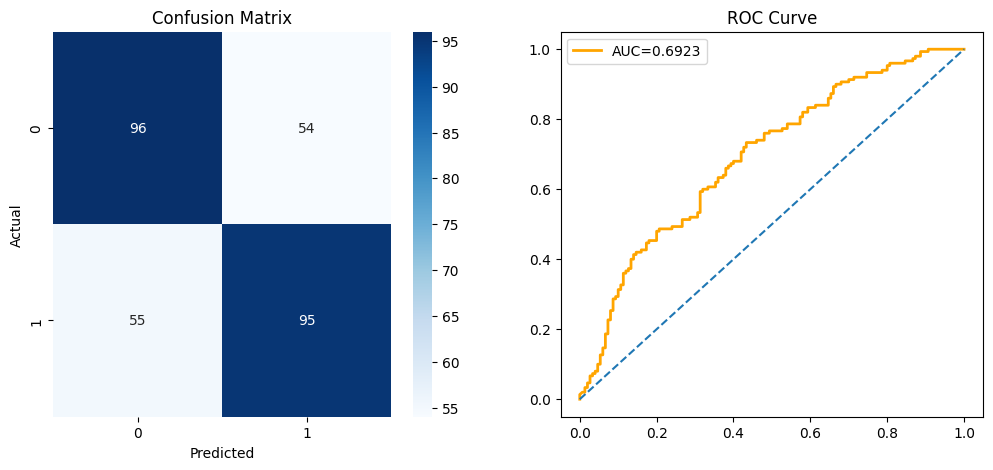

In [ ]:
# --- 6. 최종 평가 및 시각화 ---
print("\n📊 최종 결과 분석 중...")
from sklearn.metrics import precision_score, recall_score, auc
model.eval()
y_true, y_pred, y_prob = [], [], []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        out = model(x)
        prob = torch.sigmoid(out).cpu().numpy()
        pred = (prob > 0.5).astype(float)
        y_true.extend(y.numpy())
        y_pred.extend(pred)
        y_prob.extend(prob)

# 지표 출력
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"\n🏆 [EfficientNet Result]")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-Score : {f1:.4f}")

# 시각화
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("Actual")

plt.subplot(1, 2, 2)
fpr, tpr, _ = roc_curve(y_true, y_prob)
plt.plot(fpr, tpr, color='orange', lw=2, label=f'AUC={auc(fpr, tpr):.4f}')
plt.plot([0,1],[0,1], '--')
plt.title("ROC Curve")
plt.legend()
plt.show()